# Телеком                           

## "Часть 1" План работы и первичный анализ данных

In [2]:
!pip install phik
!pip install catboost
!pip install optuna
!pip install pycaret

  Using cached pycaret-3.0.2-py3-none-any.whl (483 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached category_encoders-2.6.1-py2.py3-none-any.whl (81 kB)
  Using cached pmdarima-2.0.3-cp39-cp39-win_amd64.whl (572 kB)
  Using cached plotly_resampler-0.8.3.2-cp39-cp39-win_amd64.whl
  Using cached importlib_metadata-6.6.0-py3-none-any.whl (22 kB)
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached pyod-1.0.9-py3-none-any.whl
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached sktime-0.17.0-py3-none-any.whl (16.1 MB)
     --------------------------------------- 10.3/10.3 MB 10.6 MB/s eta 0:00:00
  Using cached jupyter_dash-0.4.2-py3-none-any.whl (23 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached ansi2html-1.8.0-py3-n

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import optuna
from optuna.distributions import IntDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from optuna.distributions import FloatDistribution as fl
from optuna.distributions import IntDistribution as intd
import catboost
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.model_selection import RandomizedSearchCV
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
df_1 = pd.read_csv('/datasets/contract_new.csv')
df_2 = pd.read_csv('/datasets/personal_new.csv')
df_3 = pd.read_csv('/datasets/internet_new.csv')
df_4 = pd.read_csv('/datasets/phone_new.csv')

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_1.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<AxesSubplot:>

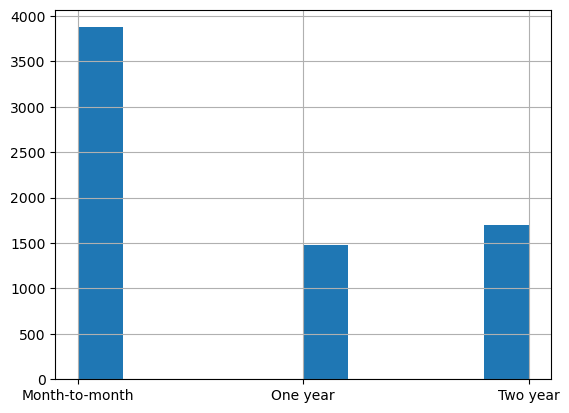

In [7]:
df_1['Type'].hist()

<AxesSubplot:>

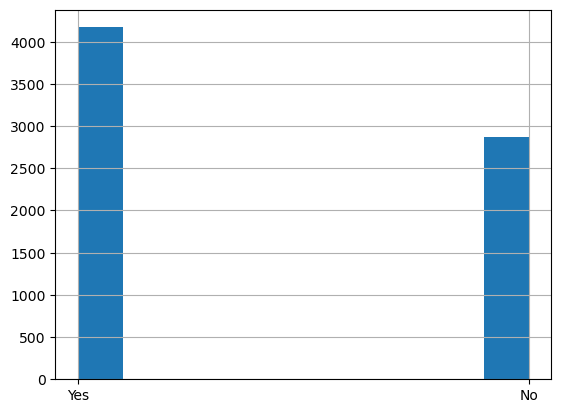

In [8]:
df_1['PaperlessBilling'].hist()

Пропусков в данных не вижу

BeginDate имеет тип object, необходимо заменить на Datetime, 

EndDate это наш целевой признак, заменим на 1 и 0,

TotalCharges  имеет тип object необходимо заменить на float64

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
df_2.head(20)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<AxesSubplot:>

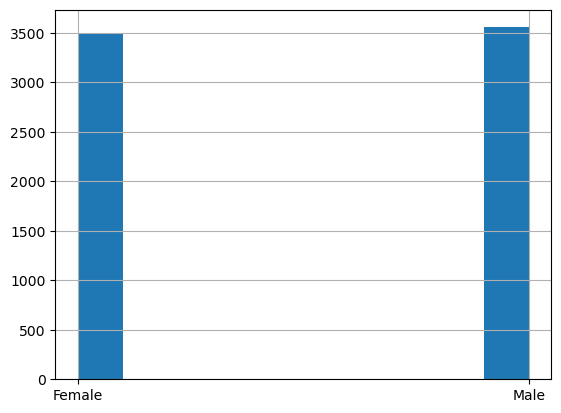

In [11]:
df_2['gender'].hist()

<AxesSubplot:>

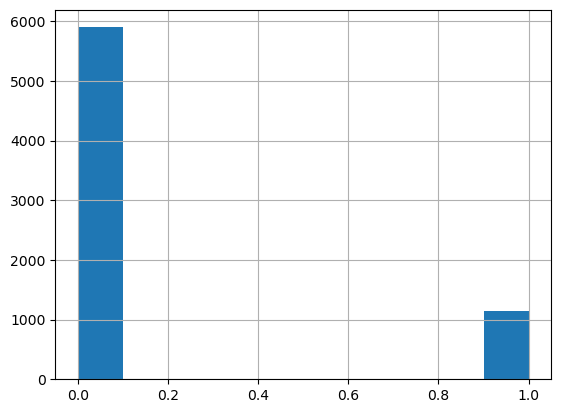

In [12]:
df_2['SeniorCitizen'].hist()

<AxesSubplot:>

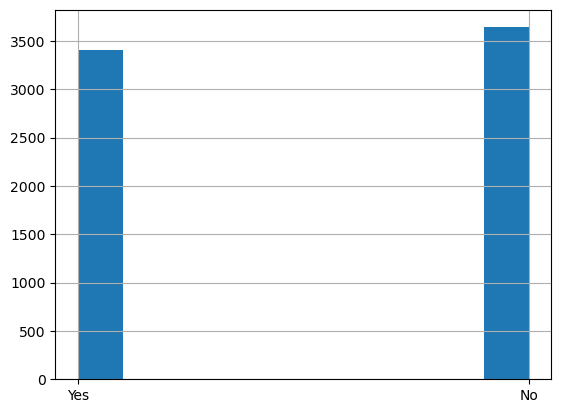

In [13]:
df_2['Partner'].hist()

<AxesSubplot:>

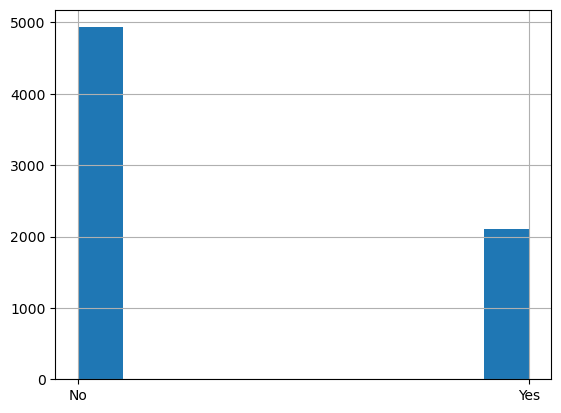

In [14]:
df_2['Dependents'].hist()

Пропусков в данных не вижу и необходимости изменения типа тоже

In [15]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
df_3.head(15)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<AxesSubplot:>

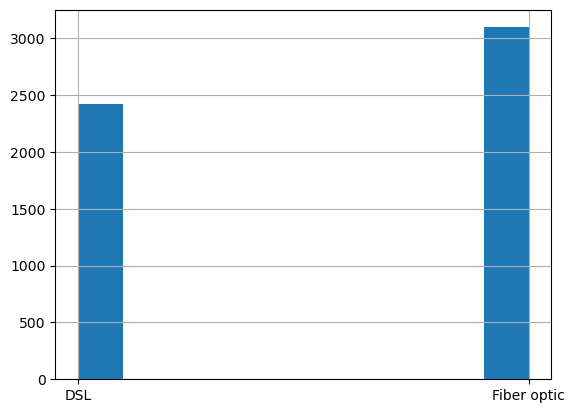

In [17]:
df_3['InternetService'].hist()

<AxesSubplot:>

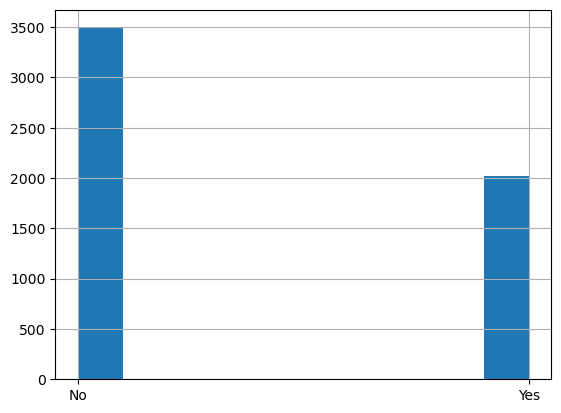

In [18]:
df_3['OnlineSecurity'].hist()

<AxesSubplot:>

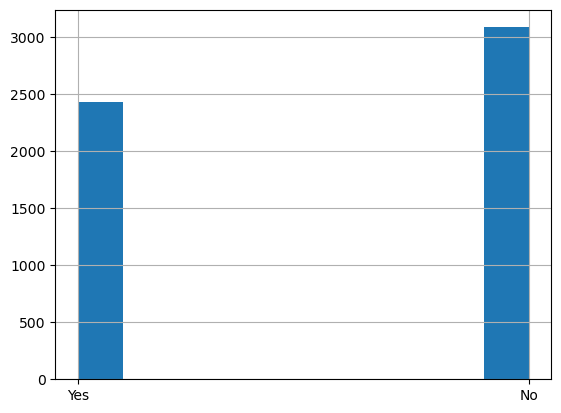

In [19]:
df_3['OnlineBackup'].hist()

<AxesSubplot:>

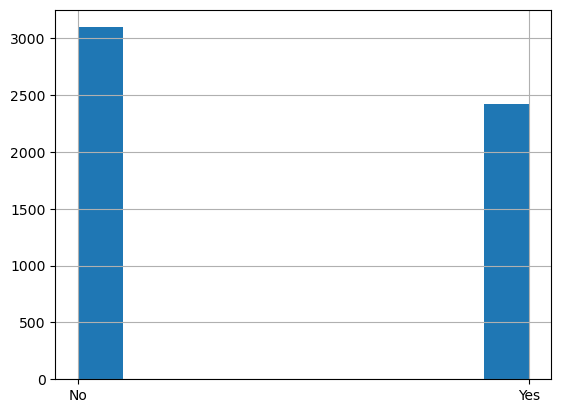

In [20]:
df_3['DeviceProtection'].hist()

<AxesSubplot:>

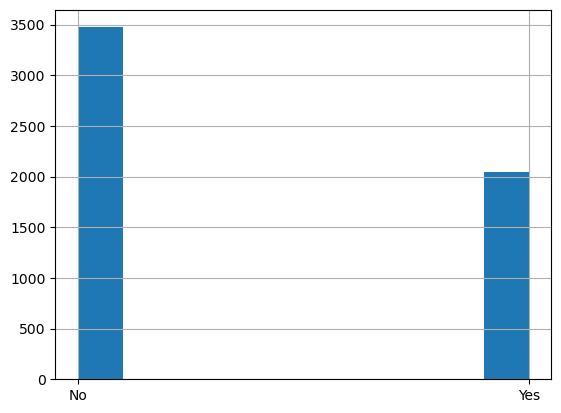

In [21]:
df_3['TechSupport'].hist()

<AxesSubplot:>

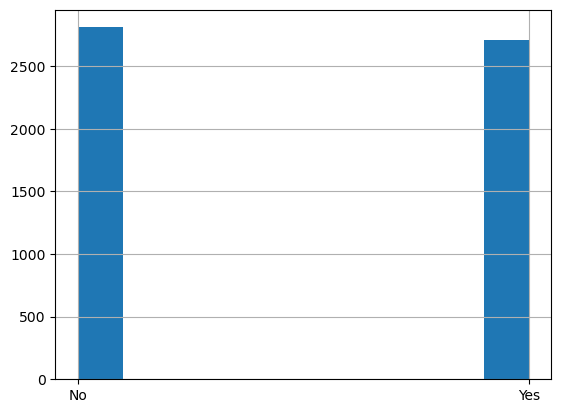

In [22]:
df_3['StreamingTV'].hist()

<AxesSubplot:>

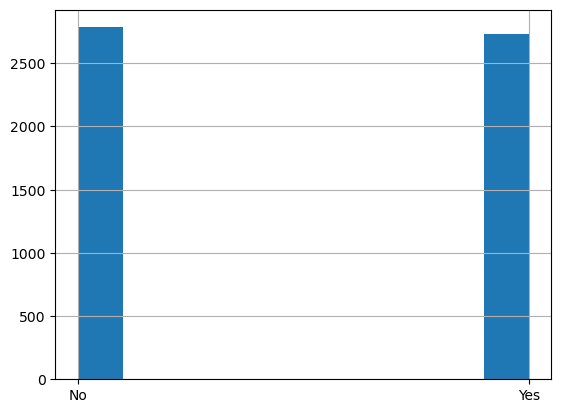

In [23]:
df_3['StreamingMovies'].hist()

Пропусков в данных не вижу и необходимости изменения типа тоже

In [24]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [25]:
df_4.head(15)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<AxesSubplot:>

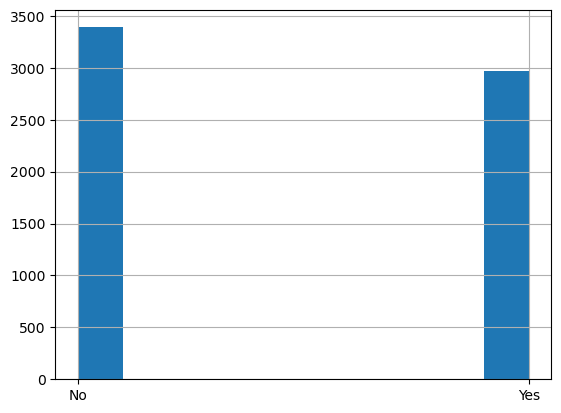

In [26]:
df_4['MultipleLines'].hist()

Пропусков в данных не вижу и необходимости изменения типа тоже

### Выводы по первичному анализу данных:

По df_1: 

BeginDate имеет тип object, необходимо заменить на Datetime, 

EndDate это наш целевой признак, заменим на 1 и 0,

TotalCharges  имеет тип object необходимо заменить на float64

В остальных таблицах заменять данные не нужно 

Пропусков в данных нет

### Уточняющих вопросов нет!

### План работы:

1. Объединение и анализ данных

1.1 объединить таблицы, 

1.2 заменить типы данных и отредактировать целевой признак,, 

1.3 проверить на пропуски и дубликаты,  

1.4 анализ на  мультиколлинеарность, 

1.5 проверка на дисбаланс классов

1.6 визуализация признаков 

2. Обучение модели 

2.1 Разбиение выборки

2.2 Кодирование признаков

2.3 Подбор модели и гиперпараметров

2.4 Выбор итоговой модели (по результатам кроссвалидации) 

2.5 Тестирование модели

2.6 Анализ важности признаков 

2.7 Матрица ошибок

## "Часть 2" Код решения

### Объединение и анализ данных:

In [27]:
df_11 = df_1.set_index('customerID')
df_22 = df_2.set_index('customerID')
df_33 = df_3.set_index('customerID')
df_44 = df_4.set_index('customerID')

In [28]:
df=df_11.join([df_22, df_33, df_44], on=None, how='outer', lsuffix='', rsuffix='', sort=False) 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

##### Визуализация признаков

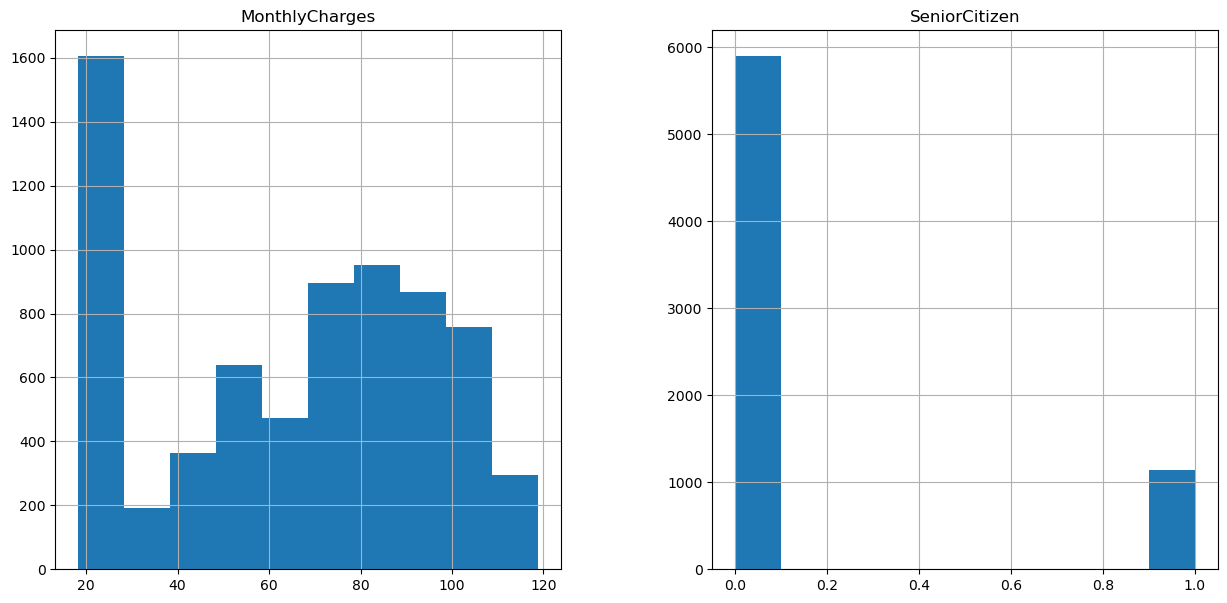

In [30]:
df.hist(bins=10, figsize=(15,7));

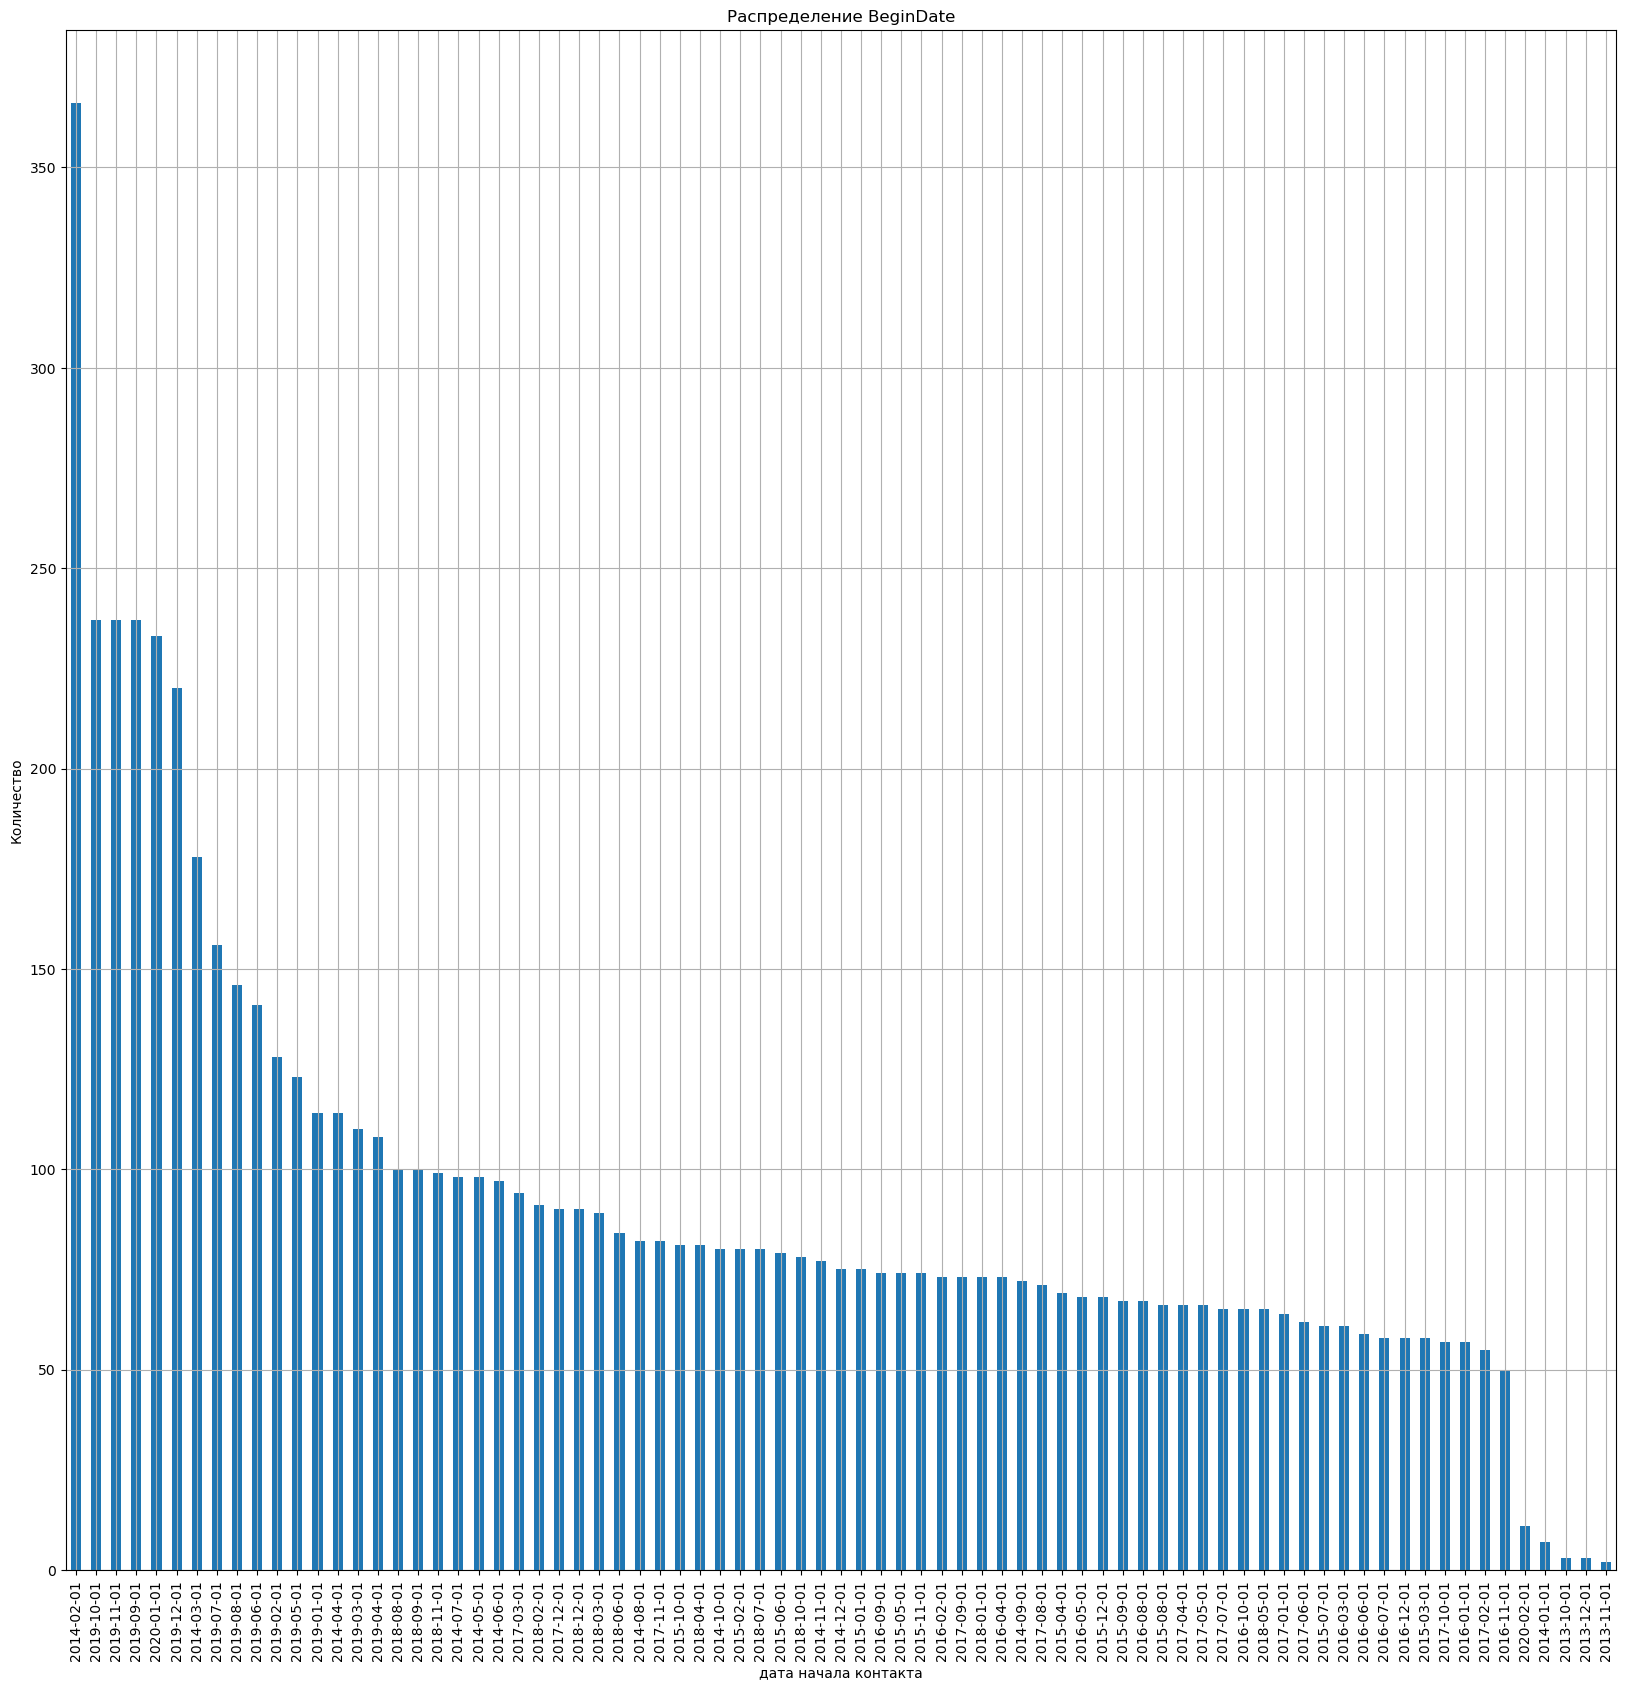

In [31]:
df['BeginDate'].value_counts().plot(xlabel='дата начала контакта', ylabel='Количество', kind='bar',grid=True, figsize=(20,20),title='Распределение BeginDate');

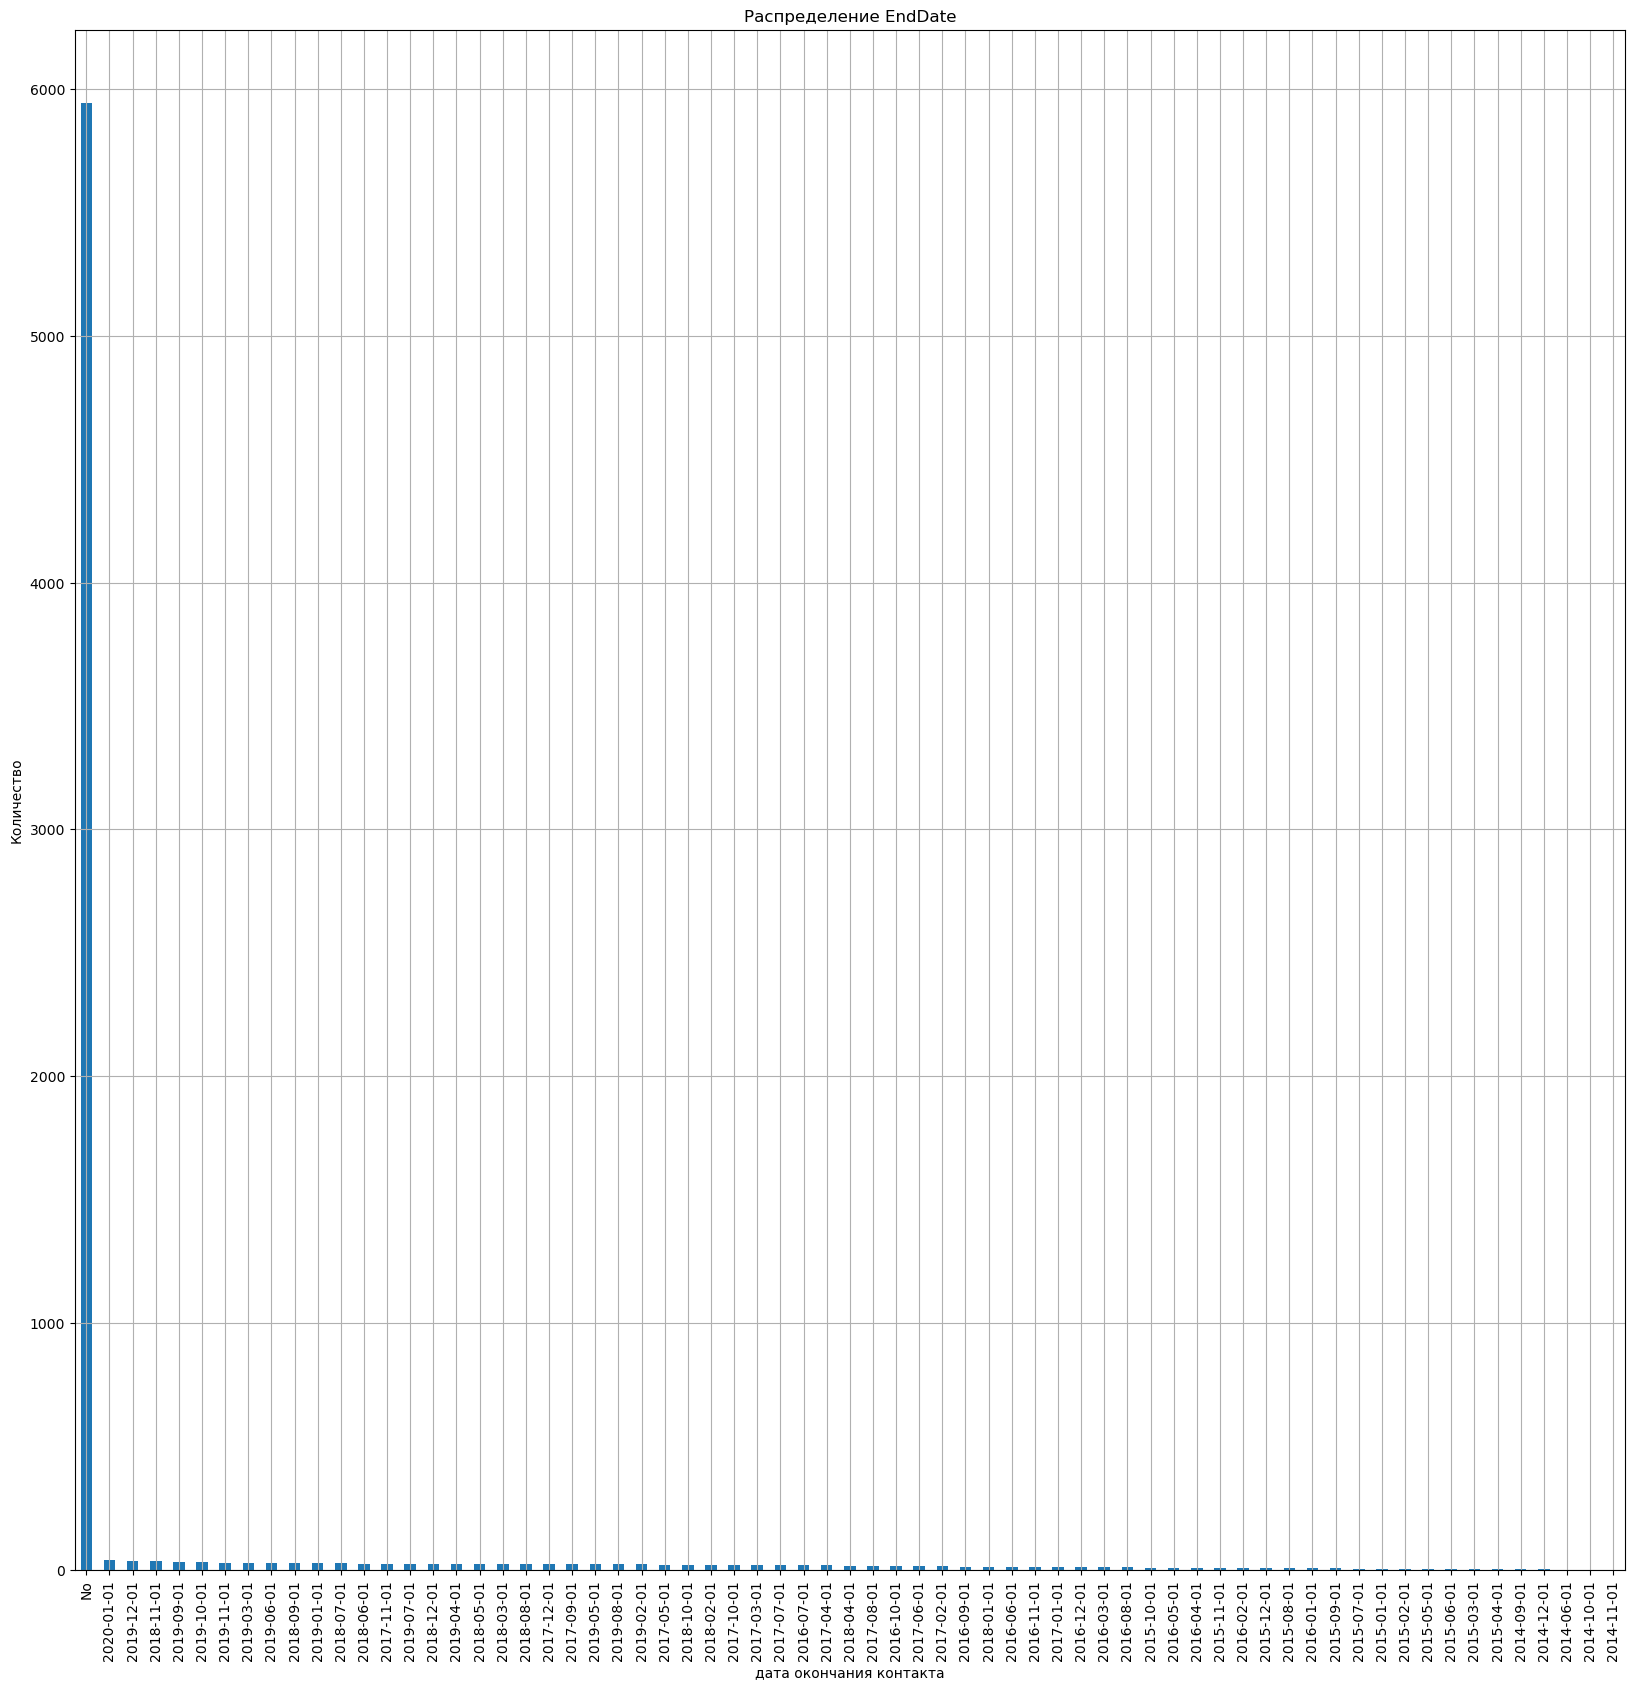

In [32]:
df['EndDate'].value_counts().plot(xlabel='дата окончания контакта', ylabel='Количество', kind='bar',grid=True, figsize=(20,20),title='Распределение EndDate');

TotalCharges не визулизируется, визуализируем после обработки

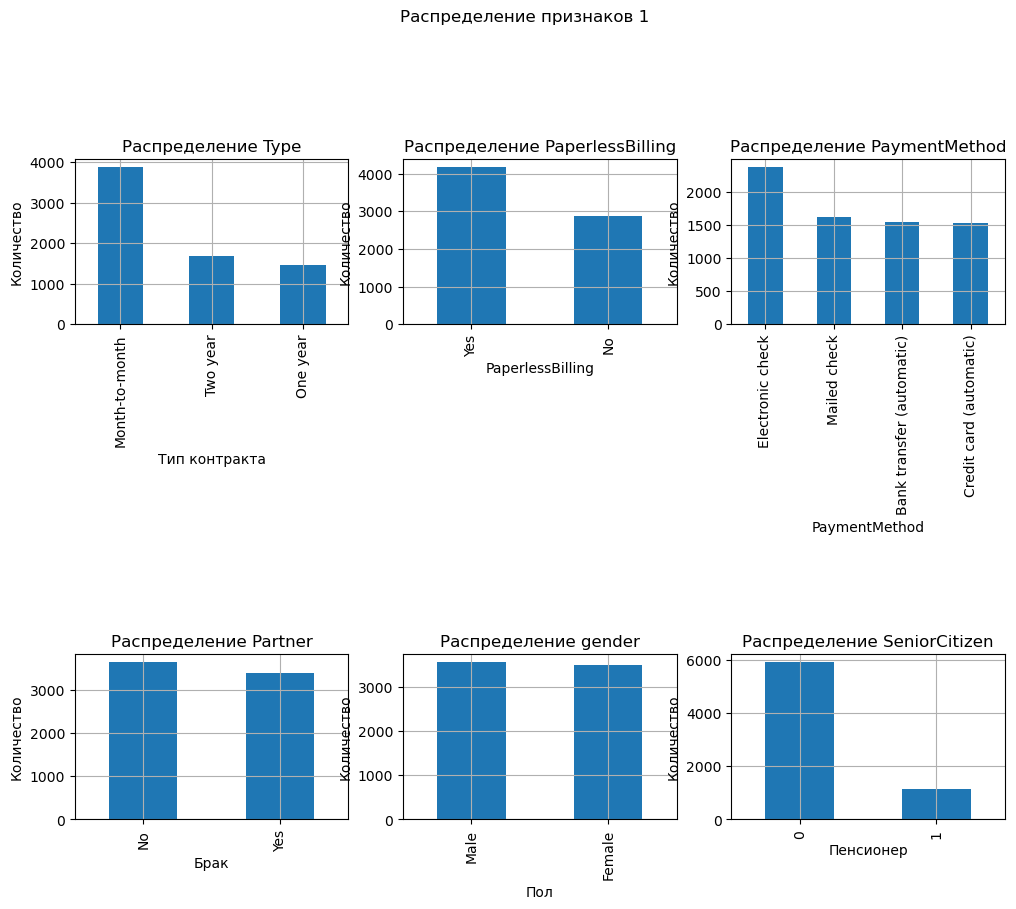

In [33]:
plt.figure(figsize=(25, 25))
plt.suptitle('Распределение признаков 1')
plt.subplots_adjust(hspace=2)
plt.subplot(3, 3, 1)
df['Type'].value_counts().plot(xlabel='Тип контракта', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение Type')
plt.subplot(3, 3, 2)
df['PaperlessBilling'].value_counts().plot(xlabel='PaperlessBilling', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение PaperlessBilling')
plt.subplot(3, 3, 3)
df['PaymentMethod'].value_counts().plot(xlabel='PaymentMethod', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение PaymentMethod')
plt.subplot(3, 3, 4)
df['Partner'].value_counts().plot(xlabel='Брак', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение Partner')
plt.subplot(3, 3, 5)
df['gender'].value_counts().plot(xlabel='Пол', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение gender')
plt.subplot(3, 3, 6)
df['SeniorCitizen'].value_counts().plot(xlabel='Пенсионер', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение SeniorCitizen');

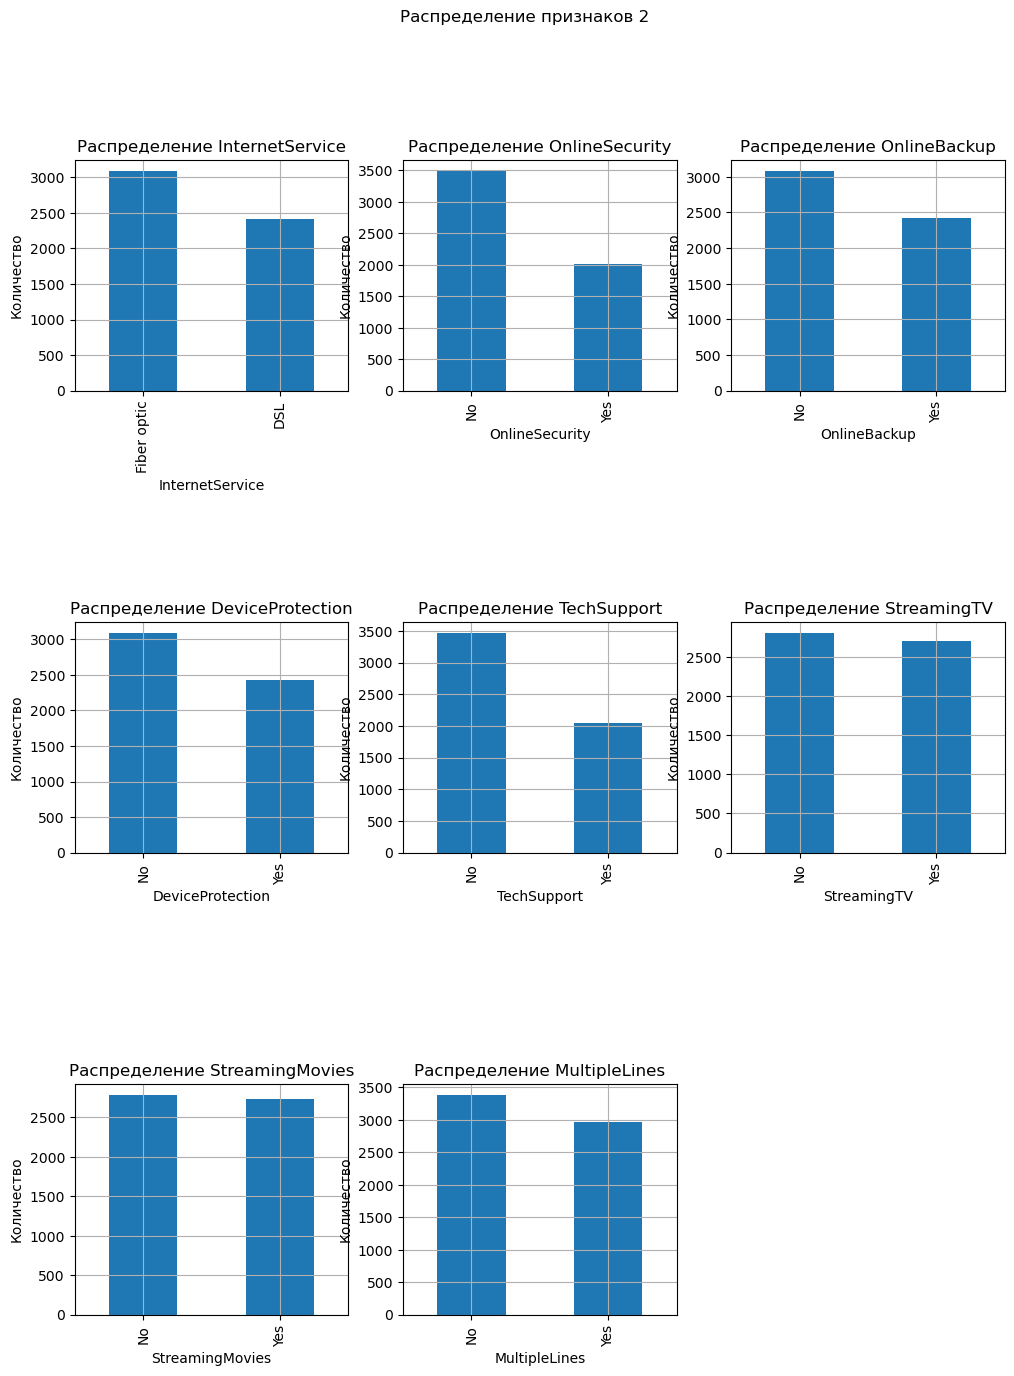

In [34]:
plt.figure(figsize=(25, 25))
plt.suptitle('Распределение признаков 2')
plt.subplots_adjust(hspace=1)
plt.subplot(3, 3, 1)
df['InternetService'].value_counts().plot(xlabel='InternetService', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение InternetService')
plt.subplot(3, 3, 2)
df['OnlineSecurity'].value_counts().plot(xlabel='OnlineSecurity', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение OnlineSecurity')
plt.subplot(3, 3, 3)
df['OnlineBackup'].value_counts().plot(xlabel='OnlineBackup', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение OnlineBackup')
plt.subplot(3, 3, 4)
df['DeviceProtection'].value_counts().plot(xlabel='DeviceProtection', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение DeviceProtection')
plt.subplot(3, 3, 5)
df['TechSupport'].value_counts().plot(xlabel='TechSupport', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение TechSupport')
plt.subplot(3, 3, 6)
df['StreamingTV'].value_counts().plot(xlabel='StreamingTV', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение StreamingTV')
plt.subplot(3, 3, 7)
df['StreamingMovies'].value_counts().plot(xlabel='StreamingMovies', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение StreamingMovies')
plt.subplot(3, 3, 8)
df['MultipleLines'].value_counts().plot(xlabel='MultipleLines', ylabel='Количество', kind='bar',grid=True, figsize=(12,15),title='Распределение MultipleLines');

##### Обработка данных

In [35]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

In [36]:
df[df['EndDate']!= 'No']['EndDate'].sort_values().tail()

customerID
3545-CNWRG    2020-01-01
8190-ZTQFB    2020-01-01
5828-DWPIL    2020-01-01
9835-ZIITK    2020-01-01
4652-NNHNY    2020-01-01
Name: EndDate, dtype: object

In [37]:
df['TotalCharges']=df['TotalCharges'].fillna(0)

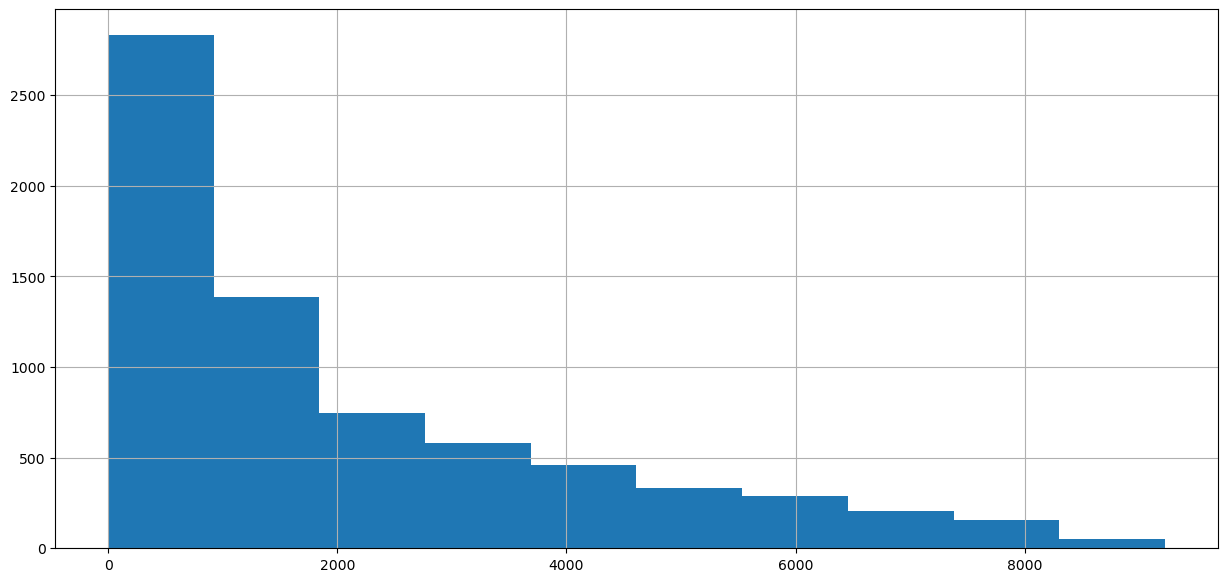

In [38]:
df['TotalCharges'].hist(bins=10, figsize=(15,7));

In [39]:
df['BeginDate']=pd.to_datetime(df['BeginDate'], format='%Y.%m.%d')
df['EndDate_cor']=df['EndDate']
df['EndDate_cor']=df['EndDate_cor'].replace('No', '2020-02-01')
df['EndDate_cor']=pd.to_datetime(df['EndDate_cor'], format='%Y.%m.%d')
df['DurationContract']=(df["EndDate_cor"] - df["BeginDate"]).dt.days
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_cor,DurationContract
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,NaN,2020-02-01,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,2020-02-01,1036
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,2020-02-01,123
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,NaN,2020-02-01,1371
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,2020-02-01,153


In [40]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('object')

In [41]:
df.loc[ df['EndDate'] == 'No', 'EndDate'] = 0
df.loc[ df['EndDate'] != 0, 'EndDate'] = 1
df['EndDate']=df['EndDate'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   int32         
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

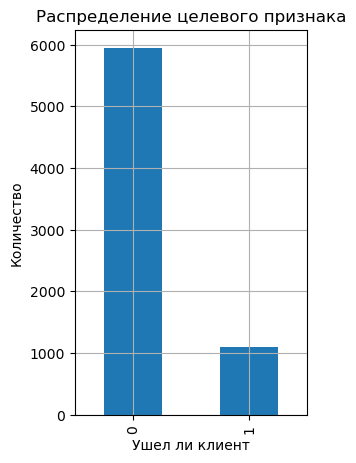

In [42]:
df['EndDate'].value_counts().plot(xlabel='Ушел ли клиент', ylabel='Количество', kind='bar',grid=True, figsize=(3,5),title='Распределение целевого признака');

In [43]:
df['InternetService']=df['InternetService'].fillna('no_internet')
df['OnlineSecurity']=df['OnlineSecurity'].fillna('no_internet')
df['OnlineBackup']=df['OnlineBackup'].fillna('no_internet')
df['DeviceProtection']=df['DeviceProtection'].fillna('no_internet')
df['TechSupport']=df['TechSupport'].fillna('no_internet')
df['StreamingTV']=df['StreamingTV'].fillna('no_internet')
df['StreamingMovies']=df['StreamingMovies'].fillna('no_internet')
df['MultipleLines']=df['MultipleLines'].fillna('no_fhone')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   int32         
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

In [44]:
df.duplicated().sum()

4

In [45]:
df = df.drop_duplicates()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           7039 non-null   int32         
 2   Type              7039 non-null   object        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   object        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   gender            7039 non-null   object        
 8   SeniorCitizen     7039 non-null   object        
 9   Partner           7039 non-null   object        
 10  Dependents        7039 non-null   object        
 11  InternetService   7039 non-null   object        
 12  OnlineSecurity    7039 non-null   object        
 13  OnlineBackup      7039 non-null   object        
 14  DeviceProtecti

In [47]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_cor,DurationContract
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,no_fhone,2020-02-01,31
5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,2020-02-01,1036
3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,2020-02-01,123
7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,no_fhone,2020-02-01,1371
9237-HQITU,2019-09-01,0,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,2020-02-01,153


##### Анализ на  мультиколлинеарность

In [48]:
df['MonthlyCharges'].corr(df['TotalCharges'])

0.6301808820774637

Корреляция в 0.63 говорит о наличии связи, однако не слишком сильной.

interval columns not set, guessing: ['EndDate', 'MonthlyCharges', 'TotalCharges', 'DurationContract']


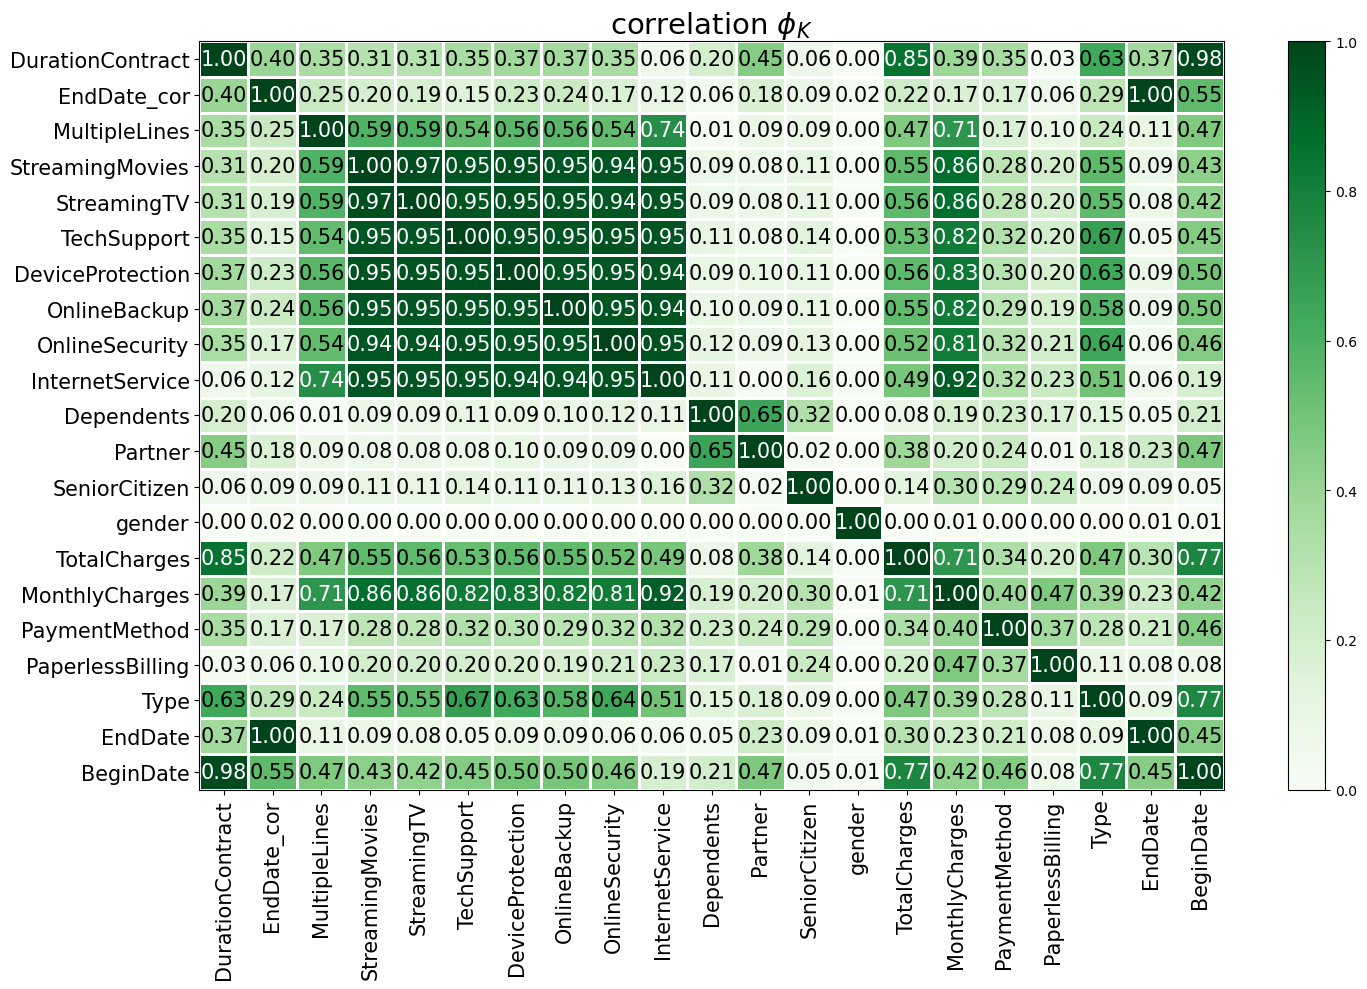

In [49]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

Все интернет сервисы сильно друг с другом коррелируют, и коррелируют с MonthlyCharges. Также высокая корреляция у BeginDate и Type/TotalCharges. 

##### Уберем из датасета информацию об интернет-услугах, BeginDate, EndDate_cor

In [72]:
df_с = df.drop(columns=['BeginDate','EndDate_cor'])

In [51]:
df_с.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7039 non-null   int32  
 1   Type              7039 non-null   object 
 2   PaperlessBilling  7039 non-null   object 
 3   PaymentMethod     7039 non-null   object 
 4   MonthlyCharges    7039 non-null   float64
 5   TotalCharges      7039 non-null   float64
 6   gender            7039 non-null   object 
 7   SeniorCitizen     7039 non-null   object 
 8   Partner           7039 non-null   object 
 9   Dependents        7039 non-null   object 
 10  InternetService   7039 non-null   object 
 11  OnlineSecurity    7039 non-null   object 
 12  OnlineBackup      7039 non-null   object 
 13  DeviceProtection  7039 non-null   object 
 14  TechSupport       7039 non-null   object 
 15  StreamingTV       7039 non-null   object 
 16  StreamingMovies   7039 non-null 

##### Проверка на дисбаланс классов

In [52]:
df_с['EndDate'].value_counts()

0    5938
1    1101
Name: EndDate, dtype: int64

Есть дисбаланс классов

In [53]:
RANDOM_STATE=220523
target = df_с['EndDate']
features = df_с.drop('EndDate', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

### Обучение моделей:

#### Модель линейная регрессия:

In [54]:
data_prep = make_column_transformer(
      (StandardScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include='object')))



In [55]:
%%time
# определяем пайплайн
model_pipe = Pipeline([('data_prep', data_prep),('predict', LogisticRegression(random_state=RANDOM_STATE))])




Wall time: 0 ns


In [56]:
%%time
model_pipe.fit(features_train, target_train)

Wall time: 131 ms


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015E3AE8FD00>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015E3AE8FCA0>)])),
                ('predict', LogisticRegression(random_state=220523))])

In [57]:
X_s, y_s = shuffle(features_train, target_train)
scores=cross_val_score(model_pipe, X_s, y_s, cv=5, scoring = "roc_auc")
score = scores.mean()
print('Средняя оценка ROC_AUC модели :', score)

Средняя оценка ROC_AUC модели : 0.7632427030034492


#### Попробуем ту же модель c балансированием классов:

In [58]:
%%time
# определяем пайплайн
model_pipe = Pipeline([('data_prep', data_prep),('predict', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))])

Wall time: 0 ns


In [59]:
%%time
model_pipe.fit(features_train, target_train)

Wall time: 57.2 ms


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015E3AE8FD00>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015E3AE8FCA0>)])),
                ('predict',
                 LogisticRegression(class_weight='balanced',
                                    random_state=220523))])

In [60]:
X_s, y_s = shuffle(features_train, target_train)
scores=cross_val_score(model_pipe, X_s, y_s, cv=5, scoring = "roc_auc")
score = scores.mean()
print('Средняя оценка ROC_AUC модели :', score)

Средняя оценка ROC_AUC модели : 0.7603149705871001


С  балансированием классов метрика не выросла. Метрика не чуствительна к дисбалансу.

#### Модель CatBoostClassifier подбор гиперпараметров OptunaSearchCV:

In [61]:
%%time
cat_features = ['Type','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'] 
clf = CatBoostClassifier(verbose=False, cat_features=cat_features)

param_distrs = {'learning_rate': fl(0.01,0.5),
                'iterations': intd(800, 1200, 100)
                
                      }

opt_search = optuna.integration.OptunaSearchCV(clf, param_distrs, cv = 5,
                                                n_trials=50, scoring='roc_auc', timeout=500, n_jobs=-1, random_state=RANDOM_STATE)
opt_search.fit(features_train, target_train)

<timed exec>:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-05-31 21:34:11,637] A new study created in memory with name: no-name-082f2655-cd4b-428c-ad23-04c290ef06d9
[I 2023-05-31 21:40:12,155] Trial 10 finished with value: 0.8947472455090093 and parameters: {'learning_rate': 0.2731819755466871, 'iterations': 801}. Best is trial 10 with value: 0.8947472455090093.
[I 2023-05-31 21:40:31,607] Trial 9 finished with value: 0.8840390819779831 and parameters: {'learning_rate': 0.4664247753938967, 'iterations': 882}. Best is trial 10 with value: 0.8947472455090093.
[I 2023-05-31 21:41:21,515] Trial 3 finished with value: 0.8975535347742767 and parameters: {'learning_rate': 0.1981584785908308, 'iterations': 1001}. Best is trial 3 with value: 0.8975535347742767.
[I 2023-05-31 21:41:21,536] Trial 0 finished with value: 0.8979116145385756 and parameters: {'learning_rate': 0.1451454046598918, 'iterations': 943}. Best

Wall time: 14min 52s


OptunaSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000015E3AE0DD00>,
               n_jobs=-1, n_trials=50,
               param_distributions={'iterations': IntDistribution(high=1200, log=100, low=800, step=1),
                                    'learning_rate': FloatDistribution(high=0.5, log=False, low=0.01, step=None)},
               random_state=220523, scoring='roc_auc', timeout=500)

In [62]:
print('Лучшие параметры:', opt_search.best_params_)
print('Лучшее значение Roc auc:', opt_search.best_score_)
print('Лучшая модель:', opt_search.best_estimator_)

Лучшие параметры: {'learning_rate': 0.2187391284095137, 'iterations': 1053}
Лучшее значение Roc auc: 0.898179624663068
Лучшая модель: <catboost.core.CatBoostClassifier object at 0x0000015E2F7249D0>


####  Модель LGBM

In [65]:
space={'max_depth':list(np.arange(10, 100, step=5)) + [None],
              'n_estimators':np.arange(10, 500, step=10),
#        'num_threads':[1] #Код ревьюера
         }

In [73]:
categorical_feature_names = ['Type','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']
for col in categorical_feature_names:
    features_train_cat[col]=features_train[col].astype('category')
features_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 3199-NPKCN to 8992-OBVDG
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5279 non-null   category
 1   PaperlessBilling  5279 non-null   category
 2   PaymentMethod     5279 non-null   category
 3   MonthlyCharges    5279 non-null   float64 
 4   TotalCharges      5279 non-null   float64 
 5   gender            5279 non-null   category
 6   SeniorCitizen     5279 non-null   category
 7   Partner           5279 non-null   category
 8   Dependents        5279 non-null   category
 9   InternetService   5279 non-null   category
 10  OnlineSecurity    5279 non-null   category
 11  OnlineBackup      5279 non-null   category
 12  DeviceProtection  5279 non-null   category
 13  TechSupport       5279 non-null   category
 14  StreamingTV       5279 non-null   category
 15  StreamingMovies   5279 non-null   category
 16  MultipleLines 

In [74]:
%%time
LGBM = LGBMClassifier(categorical_feature=categorical_feature_names)
LGBM_random = RandomizedSearchCV(LGBM, space, n_iter=500, scoring="roc_auc", n_jobs=-1, cv=3, random_state=RANDOM_STATE)
model_random = LGBM_random.fit(features_train_cat, target_train)

C:\Users\1382697\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\1382697\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Wall time: 1min 24s


In [75]:
print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))

Best hyperparameters are: {'n_estimators': 290, 'max_depth': 20}
Best score is: 0.8703874869217971


Лучшую оценку на кросс валидации показала модель:

In [77]:
model = CatBoostClassifier(random_state=RANDOM_STATE, iterations=1053, cat_features=cat_features, learning_rate=0.2187391284095137, verbose=False) 

model.fit(features_train, target_train)

## Проверка модели

In [78]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Oценка ROC_AUC модели :', auc_roc)

Oценка ROC_AUC модели : 0.9174003126566088


Необходимое значение метрики достигнуто

## Анализ важности признаков

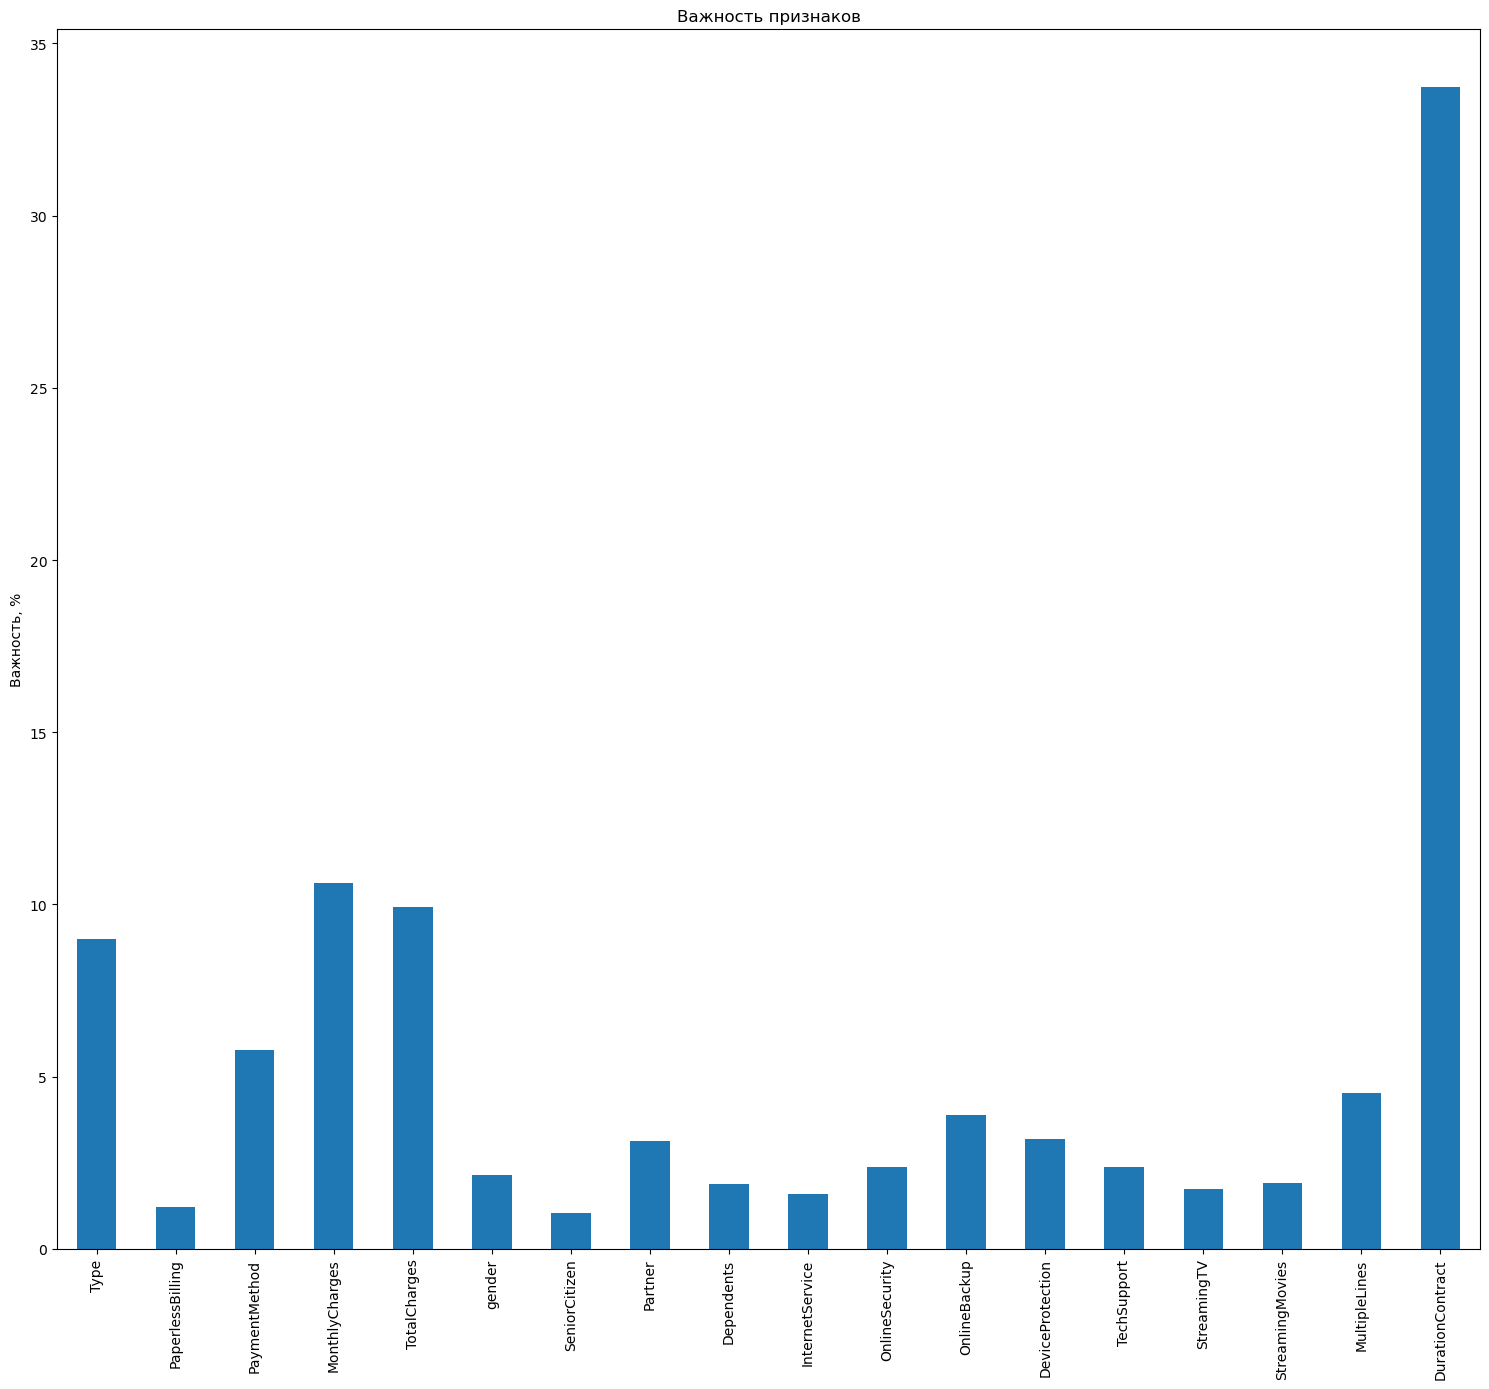

In [79]:
model_imp = pd.Series(model.get_feature_importance(),
                         features_train.columns)
fig, ax = plt.subplots(figsize=(15,14))
model_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Не важными признаками оказались PaperlessBilling, SeniorCitizen, Dependents, InternetService, StreamingTV

## Матрица ошибок

[[1465   26]
 [  98  171]]


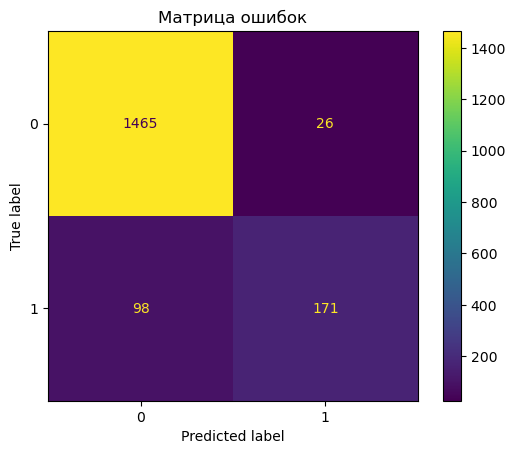

In [80]:
predicted_test = model.predict(features_test)
cm = confusion_matrix(target_test, predicted_test)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.title("Матрица ошибок")
plt.show()


Истинно негативный 1465, истинно позитивный 171, ложно негативный 98, ложно позитивный 26.

Дадут промокод лишним 26 людям, потеряют 98 клиентов